In [1]:
import torch 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize

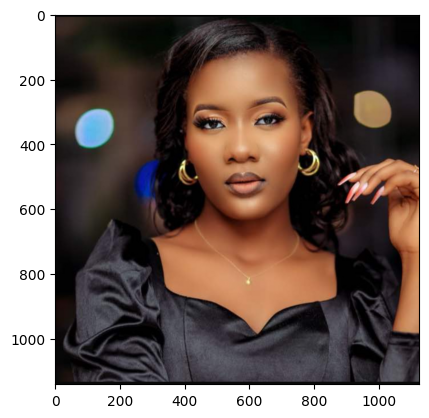

In [2]:
picture = plt.imread(r'/home/sinbad/Pictures/Camera/gloria.JPG')
picturen =resize(picture,(28,28), anti_aliasing=True)
picture_tensor = torch.from_numpy(picturen).float()
plt.imshow(picture)

In [3]:
picture_tensor.size()

torch.Size([224, 224, 3])

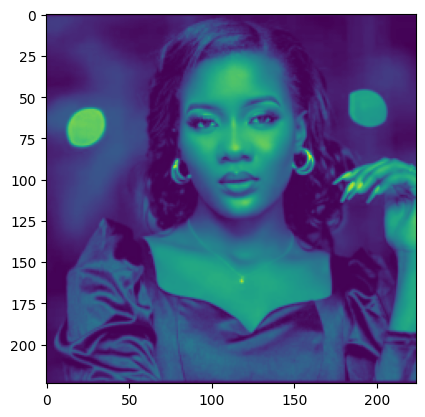

In [4]:
plt.imshow(picture_tensor[:,:,1].numpy())

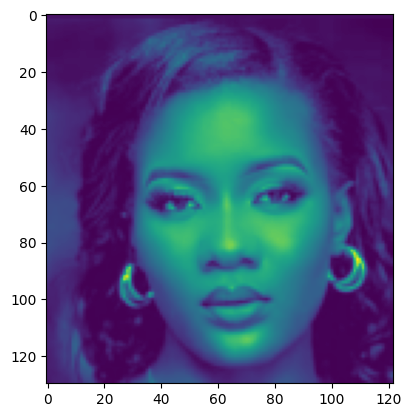

In [5]:
plt.imshow(picture_tensor[0:130,50:172,1].numpy())

Tensor addition

In [6]:
a =torch.rand(2,2)
b= torch.rand(2,2)
c = torch.add(a,b)
print(c)

tensor([[1.2650, 1.0990],
        [0.9557, 0.7917]])


In [7]:
x = torch.ones(2, 2, requires_grad=True)
y = x.mean()

In [8]:
y.backward()
# x.data

In [9]:
print(x.grad)

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


In [10]:
# mse loss

from torch.nn import Linear
from torch import nn

loss = nn.MSELoss()
input = torch.randn(3,5,requires_grad = True) 
tatget = torch.randn(3,5)
output = loss(input,tatget)
output.backward()
print(output)

tensor(1.7338, grad_fn=<MseLossBackward0>)


In [11]:
# cross entropy (loss for classification

loss = nn.CrossEntropyLoss()
input = torch.randn(3,5, requires_grad=True)
target = torch.LongTensor(3).random_(5)
output = loss(input,target)
output.backward()

In [12]:
import os
import torchvision
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 tensors
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

In [14]:
dataset= datasets.ImageFolder(root='/home/sinbad/Desktop/deep_learning/archive/train', transform=transform)
dataset_test = datasets.ImageFolder(root='/home/sinbad/Desktop/deep_learning/archive/test', transform=transform)


In [15]:
print(dataset.classes)

['cats', 'dogs']


In [16]:
dataloader = DataLoader(dataset, batch_size=16,num_workers=4)


In [17]:
model = models.resnet18(pretrained=True)  # You can choose resnet18, resnet34, resnet50, etc.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

/home/sinbad/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sinbad/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [24]:
import torch.optim as optim
import time
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [21]:
import torch
import time

num_epochs = 1
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0
    start_time = time.time()
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).float()  # Ensure labels are float
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))  # Ensure labels have the same shape
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track statistics
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Convert sigmoid output to binary predictions
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.unsqueeze(1).data)
    
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)
    elapsed_time = time.time() - start_time
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {elapsed_time:.4f}s')

torch.save(model.state_dict(), 'resnet_cats_dogs.pth')
print('Training complete')


Epoch 1/1, Loss: 0.0343, Accuracy: 0.9942, Time: 3035.2565s
Training complete


In [25]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 1. Define the architecture of your ResNet model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Adjust the output layer to match the number of classes

# 2. Load the saved state dictionary
model.load_state_dict(torch.load('/home/sinbad/Documents/resnet_cats_dogs.pth'))
model.eval()  # Set the model to evaluation mode

# 3. Preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# 4. Pass the image through the model
def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():  # No need to compute gradients for inference
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Example usage
image_path = '/home/sinbad/Documents/.jpeg'
prediction = predict(image_path)

# Assuming 0 is the class for 'cat' and 1 is the class for 'dog'
classes = ['cat', 'dog']
print(f'Predicted class: {classes[prediction]}')
print(prediction)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [28]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)

# 2. Load the saved state dictionary
model.load_state_dict(torch.load('/home/sinbad/Documents/resnet_cats_dogs.pth', map_location=device))
model.eval()

image_path = '/home/sinbad/Documents/mbwa.jpeg'
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)

with torch.no_grad():
    outputs = model(image)

# print(f'{'Dog' if outputs == 0 else 'cat'}')
print(f'{'cat' if outputs > 0.5 else 'dog'}')
print(outputs)



RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 512]) from checkpoint, the shape in current model is torch.Size([2, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).